### Assignment 04: Predicting the Stock Market

In this assignment, We will predict the Close/Last price of Microsoft stock using a Long Short-Term Memory neural network (LSTM) model. LSTM is a type of Recurrent Neural Network (RNN) that is capable of capturing and understand dependencies across multiple time steps or positions in the input sequence. This makes LSTMs particularly useful in various applications, including machine translation, sentiment analysis, speech recognition, and time series forecasting, where understanding and modeling the temporal relationships is crucial for accurate predictions.

We will use the sequence to sequence learning to make a multistep forecast. We will add two layers, a `repeat vector layer` and `time distributed dense layer` in the architecture. `A repeat vector layer` is used to repeat the context vector we get from the encoder to pass it as an input to the decoder. We will repeat it for n-steps ( n is the no of future steps you want to forecast). The output received from the decoder with respect to each time step is mixed. The `time distributed` densely will apply a fully connected dense layer on each time step and separates the output for each timestep. The time distributed densely is a wrapper that allows applying a layer to every temporal slice of an input.

We will stack additional layers on the encoder part and the decoder part of the sequence to sequence model. By stacking LSTM’s, it may increase the ability of our model to understand more complex representation of our time-series data in hidden layers, by capturing information at different levels.

#### Importing Libraries

In [220]:
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import RepeatVector, TimeDistributed

pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

#### Loading  Dataset

The dataset is 10 y.o. historical prices of Microsoft stock listed in the Nasdaq market. From the data, we select the values of the Close/Last column as the dataset for the model. The “Open” column represents the opening price for shares that day and the “High” column represents the highest price shares reached that day. “Low” represents the lowest share price for the day, “Last” represents the price at which the last transaction for a share went through. “Close” represents the price shares ended at for the day.

In [221]:
# loading the dataset 
msft_df =pd.read_csv('MSFT_stock.csv',parse_dates=['Date'],
                     index_col=['Date'], low_memory=False)
msft_df.rename(columns={'Close/Last': 'Close'}, 
               inplace=True, errors='raise')
msft_df.sort_values(by=['Date'], inplace=True)

# Remove currency symbols and convert dtype to float.
msft_df['Close'] = msft_df['Close'].str.replace('$', '', 
                                                regex=False).astype(float)
msft_df['Open'] = msft_df['Open'].str.replace('$', '', 
                                              regex=False).astype(float)
msft_df['High'] = msft_df['High'].str.replace('$', '', 
                                              regex=False).astype(float)
msft_df['Low'] = msft_df['Low'].str.replace('$', '', 
                                            regex=False).astype(float)
msft_df.head()

,Close,Volume,Open,High,Low
Date,,,,,
2013-07-29,31.54,28870360,31.47,31.60,31.400
2013-07-30,31.85,45799480,31.78,32.12,31.550
2013-07-31,31.84,43898440,31.97,32.05,31.710
2013-08-01,31.67,42499400,32.06,32.09,31.600
2013-08-02,31.89,29120110,31.69,31.90,31.565


#### Visualizaing Data
It is important to show the historical close prices movement of Microsoft (MSFT) by plotting a line chart. 

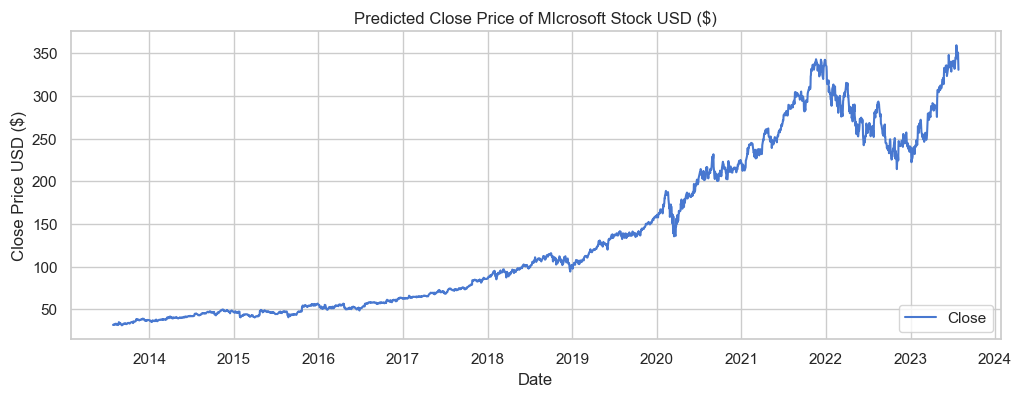

In [231]:
# Visualizing Close prices of Microsoft
plt.figure(figsize=(12, 4))
plt.title('Predicted Close Price of MIcrosoft Stock USD ($)')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(msft_df.Close)
plt.legend(['Close'], loc='lower right')
plt.show()

#### Data Preporcessing

##### _1. Preparation of Training  and Test Dataset_ 
The number of instances is 2,517. We will split the Close prices into train and test data in a 75% and 25% ratio of the instances (ie., 1,887 training dataset and 630 test dataset). 

In [168]:
# Split Close prices into training data and test data. 
msft = msft_df.iloc[:, :1].values

train_size = int(len(msft) * 0.75)
test_size = len(msft) - train_size

train_size, test_size

(1887, 630)

#### _2. Data Normalization_
Normalization is changing the values of numeric columns in the dataset to a common scale, which helps the performance of our model. To scale the  dataset we use Scikit-Learn’s MinMaxScaler with numbers between zero and one.

In [169]:
# Scaling dataset with numbers between 0 and 1
sc = MinMaxScaler(feature_range=(0,1))
sc_msft = sc.fit_transform(msft.reshape(-1,1))

train_msft = sc_msft[0: train_size, :]
test_msft = sc_msft[train_size-30: , : ]

##### _3. Incorporating Timesteps Into Data_
Before we use this data to train our model, we need to split the data into subsequences because this is a time series modelling project. We can create specific sequences with specific time steps. In this case, we will use time steps as 30. We can create sequences worth 30 days of historical data and as required by LSTM, we need to reshape our input data into n times the shape and sample features.

In [170]:
# Create 30 days of historical data and reshape it.
time_steps = 30

X_train = []
y_train = []

for i in range(time_steps, len(train_msft)):    
    X_train.append(train_msft_sc[i-time_steps:i, 0])
    y_train.append(train_msft_sc[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [171]:
x_test = []
y_test = msft[train_size:]

for i in range(time_steps, len(test_msft)):
    x_test.append(test_msft[i-time_steps:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#### Model Architecture
We will be using the Sequential model class from Keras API. A LSTM layer will be added with the following arguments: 128 units (this is the dimensionality of the output space), set return_sequences=True (this is necessary for stacking LSTM layers so the consequent LSTM layer has a three-dimensional sequence input), and input_shape (this is the shape of the training dataset).We will by specifying 0.2 in the Dropout layer, meaning that 20% of the layers will be dropped. Since the subsequent layer is an LSTM, we need to duplicate this using a RepeatVector layer. This RepeatVector layer repeats the feature vector layer from the output of the LSTM timesteps times which is 30 in this case. Now to create the decoder, we mirror the encoder in reverse fashion to create our decoder. Then we add Time distributed layer so that we can get the output of the right shape where the number of nodes is equal to number of features. The time distributed layer creates a vector equal to the number of layers output from the previous layer. We add another LSTM layer with 64 network units. But we set the return_sequence to false for this time to only return the last output in the output sequence. Lastly, we add a densely connected layer that specifies the output of 1 network unit. Mean squared error is the loss function for optimizing the model with adam optimizer.

In [181]:
timesteps, num_features = X_train.shape[1], X_train.shape[2]

In [190]:
model = Sequential([    
    LSTM(128, input_shape=(timesteps, num_features)),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    TimeDistributed(Dense(64)),
    LSTM(units=64),
    Dense(num_features)
    ], name='Stock_Predictor')

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "Stock_Predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 128)               66560     
                                                                 
 repeat_vector_12 (RepeatVe  (None, 30, 128)           0         
 ctor)                                                           
                                                                 
 lstm_42 (LSTM)              (None, 30, 128)           131584    
                                                                 
 time_distributed_12 (TimeD  (None, 30, 64)            8256      
 istributed)                                                     
                                                                 
 lstm_43 (LSTM)              (None, 64)                33024     
                                                                 
 dense_24 (Dense)            (None, 1)             

From the above model configuration, we can see that the Repeat Vector just duplicated the encoded representation 30 times. The time distributed layer decode the output layer and created 8256. Now let's train the model.

#### Train the model

In [191]:
model.fit(X_train,y_train,epochs=100,batch_size=32,shuffle=False)

Epoch 1/100
59/59 [==============================] - 12s 55ms/step - loss: 0.0315
Epoch 2/100
59/59 [==============================] - 6s 95ms/step - loss: 0.0303
Epoch 3/100
59/59 [==============================] - 5s 92ms/step - loss: 0.0298
Epoch 4/100
59/59 [==============================] - 2s 42ms/step - loss: 0.0167
Epoch 5/100
59/59 [==============================] - 3s 46ms/step - loss: 0.0165
Epoch 6/100
59/59 [==============================] - 5s 88ms/step - loss: 0.0109
Epoch 7/100
59/59 [==============================] - 5s 83ms/step - loss: 0.0101
Epoch 8/100
59/59 [==============================] - 3s 51ms/step - loss: 0.0088
Epoch 9/100
59/59 [==============================] - 3s 47ms/step - loss: 0.0079
Epoch 10/100
59/59 [==============================] - 5s 83ms/step - loss: 0.0062
Epoch 11/100
59/59 [==============================] - 6s 98ms/step - loss: 0.0045
Epoch 12/100
59/59 [==============================] - 3s 50ms/step - loss: 0.0031
Epoch 13/100
59/59 [====

Epoch 98/100
59/59 [==============================] - 5s 87ms/step - loss: 1.4672e-04
Epoch 99/100
59/59 [==============================] - 3s 48ms/step - loss: 1.3766e-04
Epoch 100/100
59/59 [==============================] - 3s 53ms/step - loss: 1.3407e-04


#### Making Predictions on the future stock (Test Set)
We apply the model to predict the stock prices based on the test set. We use the inverse_transform method to denormalize the predicted stock prices. We apply the RMSE formula to calculate the degree of discrepancy between the predicted prices and real prices _(y_test)_ and display the result.

In [192]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

20/20 [==============================] - 2s 35ms/step


1.1528431987459704

The result shows that the RMSE is as low as about __1.15__. This means the model is working well.

#### Plotting the Results
At this stage, we use matplotlib to visualize the result of our predicted stock price and the actual stock price. We use the filter method to only retain the closing price column in the dataframe. We then split our stock data into three plotting regions: training, validation and prediction. Finally, we configure the chart figure size, title, x-axis & y-axis label and legends.

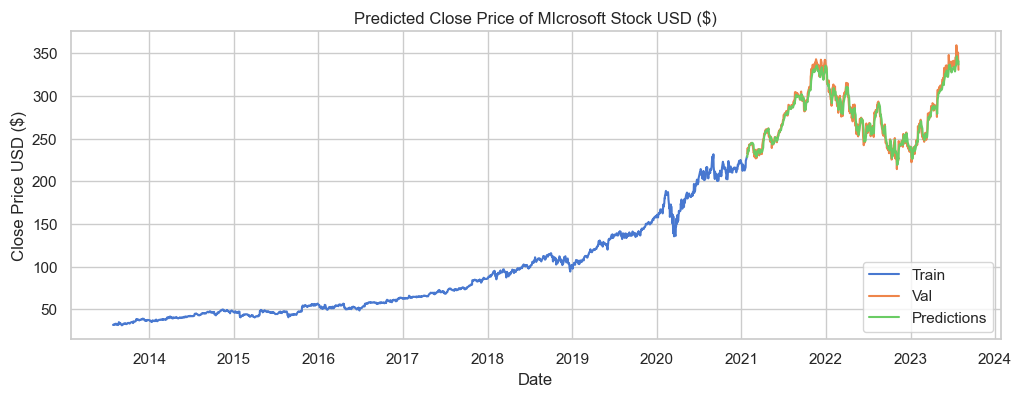

In [217]:
data = msft_df.filter(['Close'])
train = data[:train_size]
validation = data[train_size:]
validation['Predictions'] = predictions
plt.figure(figsize=(12, 4))
plt.title('Predicted Close Price of MIcrosoft Stock USD ($)')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

From the resulting chart above, we can see the predicted stock prices follow the trend of the real stock prices closely. This shows the effectiveness of the LSTM to work with time series or sequential data like the stock prices.